## A3: Classification and Feature Engineering

### Anthony Buttitta         
#### MIS 3080-01

In [28]:
# A column that indicates if the incubent won the county (>50%) or did not
# Another column that indicates if the incumbent lost, won, or won by a landslide (>65%)

# The training and test data set should include the categorical attributes State and Region.
# Set the random state to 35. 
# Consider feature engineering opportunities to help support your model’s performance and 
# document choices you have made.


In [29]:
#Create a classification model to best predict the incumbent’s win (or not) for a county. Evaluate the
# model’s learning curve. Predict the results for Delaware County, PA.
# 5. Create a classification model to predict the incumbent’s lose, win or landslide victory for a county.
# Evaluate the model’s learning curve. Predict the results for Delaware County, PA.
# 6. Make a feature change to your model and document the impact this adjustment had on your 2
# classification models and their performance.

### Import Modules

In [30]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#scikit learn imports
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score, roc_curve, roc_auc_score

### Function Defintions

In [31]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [32]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [33]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

### Source Data

In [34]:
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt4/"

#compressedfile = "housing.tgz"
filename = 'COVID_31Dec2021.csv'

#download data files if not currently downloaded into the current working directory
downloadDataResource(filename, path)

#create the dataframe
covid = pd.read_csv(filename)

Data resource COVID_31Dec2021.csv already downloaded.


In [35]:
filename2 = "ElectionEconomicSocialDataByFIPS.csv"

#download data files if not currently downloaded into the current working directory
downloadDataResource(filename2, path)

#create the dataframe
fips = pd.read_csv(filename2)

Data resource ElectionEconomicSocialDataByFIPS.csv already downloaded.


In [36]:
data = pd.merge(covid, fips, left_on='fips', right_on='fips', how='inner')

### Explore Data

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 0 to 3139
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fips              3140 non-null   int64  
 1   state             3140 non-null   object 
 2   county            3140 non-null   object 
 3   population        3140 non-null   int64  
 4   vaccinationRate   3007 non-null   float64
 5   cases             3140 non-null   int64  
 6   deaths            3140 non-null   int64  
 7   Region            3140 non-null   object 
 8   MedianIncome      3140 non-null   int64  
 9   PovertyEst        3140 non-null   int64  
 10  LaborForce        3140 non-null   int64  
 11  UnemploymentRate  3140 non-null   float64
 12  Older             3004 non-null   float64
 13  Urban             3004 non-null   float64
 14  Trump2016         3004 non-null   float64
 15  Trump2020         3004 non-null   float64
 16  RepGov            3004 non-null   float64


In [38]:
data.dropna( subset=['Trump2020'], inplace=True )

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3004 entries, 0 to 3047
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fips              3004 non-null   int64  
 1   state             3004 non-null   object 
 2   county            3004 non-null   object 
 3   population        3004 non-null   int64  
 4   vaccinationRate   2873 non-null   float64
 5   cases             3004 non-null   int64  
 6   deaths            3004 non-null   int64  
 7   Region            3004 non-null   object 
 8   MedianIncome      3004 non-null   int64  
 9   PovertyEst        3004 non-null   int64  
 10  LaborForce        3004 non-null   int64  
 11  UnemploymentRate  3004 non-null   float64
 12  Older             3004 non-null   float64
 13  Urban             3004 non-null   float64
 14  Trump2016         3004 non-null   float64
 15  Trump2020         3004 non-null   float64
 16  RepGov            3004 non-null   float64


In [40]:
data.describe()

,fips,population,vaccinationRate,cases,deaths,MedianIncome,PovertyEst,LaborForce,UnemploymentRate,Older,Urban,Trump2016,Trump2020,RepGov,Female,AdherentPercent
count,3004.000000,3.004000e+03,2873.000000,3.004000e+03,3004.000000,3004.000000,3.004000e+03,3.004000e+03,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000
mean,29895.236019,1.062064e+05,0.481671,1.744259e+04,267.076232,57083.105526,1.246958e+04,5.188906e+04,6.725999,17.094656,41.544511,63.773145,65.120572,0.595539,0.169441,51.599157
std,14560.591119,3.395493e+05,0.113674,5.672387e+04,887.783519,14531.876769,4.269069e+04,1.687269e+05,2.232475,4.307711,31.448990,15.561126,16.054708,0.490869,0.375203,18.263000
min,1001.000000,4.630000e+02,0.030000,2.700000e+01,0.000000,22901.000000,4.900000e+01,2.310000e+02,1.700000,4.691211,0.000000,8.342566,8.730038,0.000000,0.000000,3.064889
25%,18182.500000,1.108025e+04,0.404000,1.884500e+03,34.750000,47505.750000,1.479750e+03,4.879250e+03,5.200000,14.434070,13.110000,55.064585,55.871205,0.000000,0.000000,38.589889
50%,29112.000000,2.602100e+04,0.470000,4.551500e+03,82.000000,54805.500000,3.527000e+03,1.155400e+04,6.500000,16.749255,40.555000,67.048675,68.561070,1.000000,0.000000,49.915000
75%,42095.500000,6.815100e+04,0.548000,1.183500e+04,195.000000,63480.750000,8.616500e+03,3.146025e+04,8.000000,19.269340,66.860000,75.201360,77.524547,1.000000,0.000000,62.560722
max,55005.000000,1.003911e+07,1.304000,1.697286e+06,27637.000000,160305.000000,1.289368e+06,4.921499e+06,22.500000,55.481680,100.000000,95.272730,96.181820,1.000000,1.000000,192.460889


<AxesSubplot:>

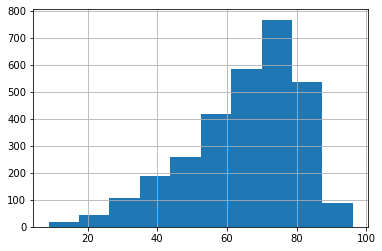

In [41]:
data.Trump2020.hist()

In [42]:
data.head()

,fips,state,county,population,vaccinationRate,cases,deaths,Region,MedianIncome,PovertyEst,LaborForce,UnemploymentRate,Older,Urban,Trump2016,Trump2020,RepGov,Female,AdherentPercent
0,1001,AL,Autauga County,55869,0.384,11013,160,Southeast,67565,6242,25838,4.9,13.35160,58.00,73.43579,71.43681,1.0,1.0,67.687889
1,1003,AL,Baldwin County,223234,0.476,39818,593,Southeast,71135,20189,96763,5.6,18.08256,57.72,77.35147,76.17137,1.0,1.0,53.174000
2,1005,AL,Barbour County,24686,0.419,3850,81,Southeast,38866,5548,8587,7.0,17.12386,32.21,52.27142,53.45123,1.0,1.0,54.999000
3,1007,AL,Bibb County,22394,0.326,4524,95,Southeast,50907,3549,8640,6.6,15.13983,31.65,76.96616,78.42627,1.0,1.0,49.880000
4,1009,AL,Blount County,57826,0.296,11244,198,Southeast,55203,7525,24661,4.1,16.11238,10.05,89.85188,89.57156,1.0,1.0,65.162000


In [43]:
data.corr()

,fips,population,vaccinationRate,cases,deaths,MedianIncome,PovertyEst,LaborForce,UnemploymentRate,Older,Urban,Trump2016,Trump2020,RepGov,Female,AdherentPercent
fips,1.000000,-0.055688,0.068399,-0.058731,-0.056899,0.035610,-0.052175,-0.052460,0.068278,0.039899,-0.013354,0.059207,0.066444,-0.062827,-0.168385,0.067075
population,-0.055688,1.000000,0.314816,0.975808,0.952103,0.290953,0.966026,0.997933,0.197135,-0.228361,0.397444,-0.350298,-0.358521,-0.078205,-0.061456,-0.051947
vaccinationRate,0.068399,0.314816,1.000000,0.287459,0.259683,0.438571,0.248964,0.320786,0.220009,-0.090385,0.413451,-0.654104,-0.672125,-0.315744,0.070089,-0.083412
cases,-0.058731,0.975808,0.287459,1.000000,0.969440,0.247530,0.958124,0.971270,0.196557,-0.221734,0.384487,-0.319030,-0.324327,-0.059956,-0.060751,-0.038798
deaths,-0.056899,0.952103,0.259683,0.969440,1.000000,0.195570,0.960205,0.942161,0.224242,-0.183264,0.358004,-0.299915,-0.302832,-0.051920,-0.057104,-0.031854
MedianIncome,0.035610,0.290953,0.438571,0.247530,0.195570,1.000000,0.169497,0.308884,-0.140587,-0.304593,0.406996,-0.245319,-0.287782,-0.173562,-0.033070,-0.057314
PovertyEst,-0.052175,0.966026,0.248964,0.958124,0.960205,0.169497,1.000000,0.954943,0.221280,-0.211202,0.358146,-0.330960,-0.332232,-0.057126,-0.054841,-0.043329
LaborForce,-0.052460,0.997933,0.320786,0.971270,0.942161,0.308884,0.954943,1.000000,0.185946,-0.234106,0.399792,-0.355551,-0.364773,-0.078665,-0.060235,-0.049850
UnemploymentRate,0.068278,0.197135,0.220009,0.196557,0.224242,-0.140587,0.221280,0.185946,1.000000,-0.098616,0.244635,-0.404858,-0.395626,-0.236569,-0.140786,-0.283208
Older,0.039899,-0.228361,-0.090385,-0.221734,-0.183264,-0.304593,-0.211202,-0.234106,-0.098616,1.000000,-0.488898,0.310162,0.316185,-0.074619,0.100036,0.034556


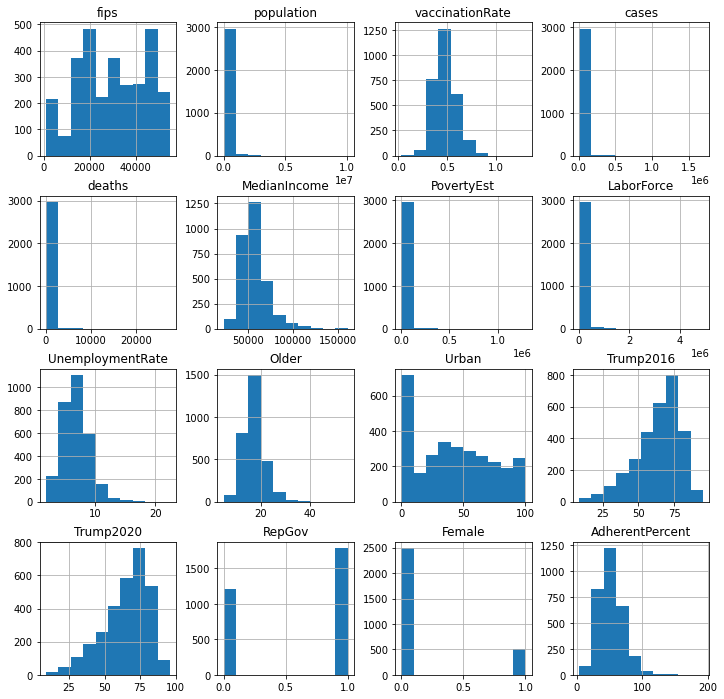

In [44]:
data.hist(figsize=(12,12))
plt.show()

<AxesSubplot:>

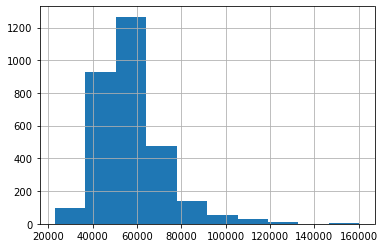

In [45]:
data.MedianIncome.hist()

In [46]:
data.MedianIncome.mean()

57083.10552596538

In [47]:
data.MedianIncome.median()

54805.5

In [48]:
data.Trump2020.mean()

65.12057191344881

In [49]:
data.Trump2020.median()

68.56107

### Transform the Data

In [50]:
data['Win']=data['Trump2020'].apply(lambda x: 1 if x > 50. else 0)

In [51]:
data["cases_per_cap"] = (data["cases"] / data["population"])*100000
data["deaths_per_cap"] = (data["deaths"] / data["population"])*100000

In [52]:
data["Labor_rate"] = data["LaborForce"]/data["population"]
data["Poverty_rate"] = data["PovertyEst"]/data["population"]
data["Fatality_rate"] = data["deaths"]/data["cases"]

In [53]:
data.sort_values(["deaths_per_cap"], ascending = False).head(20)

,fips,state,county,population,vaccinationRate,cases,deaths,Region,MedianIncome,PovertyEst,...,Trump2020,RepGov,Female,AdherentPercent,Win,cases_per_cap,deaths_per_cap,Labor_rate,Poverty_rate,Fatality_rate
2926,51640,VA,Galax city,6347,0.538,1758,69,Southeast,40271,1125,...,69.67400,0.0,0.0,76.825000,1,27698.125098,1087.127777,0.453915,0.177249,0.039249
455,13141,GA,Hancock County,8457,0.486,1264,83,Southeast,36424,2202,...,27.78714,1.0,0.0,35.220889,0,14946.198416,981.435497,0.299397,0.260376,0.065665
2395,46073,SD,Jerauld County,2013,0.495,337,19,Plains,49086,276,...,71.66998,1.0,1.0,68.565889,1,16741.182315,943.864878,0.584203,0.137109,0.056380
917,20063,KS,Gove County,2636,0.460,625,23,Plains,57676,258,...,87.64829,0.0,1.0,57.105889,1,23710.166920,872.534143,0.555766,0.097876,0.036800
2598,48155,TX,Foard County,1155,0.416,189,10,Southwest,40955,184,...,80.76225,1.0,0.0,104.192000,1,16363.636364,865.800866,0.498701,0.159307,0.052910
2921,51595,VA,Emporia city,5346,0.461,887,46,Southeast,42895,959,...,31.66737,0.0,0.0,75.653889,0,16591.844370,860.456416,0.438459,0.179386,0.051860
1091,21201,KY,Robertson County,2108,0.368,449,18,Southeast,49529,371,...,77.13787,1.0,0.0,23.093889,1,21299.810247,853.889943,0.373814,0.175996,0.040089
406,13043,GA,Candler County,10803,0.422,1623,90,Southeast,42583,2143,...,70.70638,1.0,0.0,43.135000,1,15023.604554,833.101916,0.521429,0.198371,0.055453
1650,30109,MT,Wibaux County,969,0.270,179,8,Rocky Mountain,51368,107,...,86.28762,0.0,0.0,88.003889,1,18472.652219,825.593395,0.468524,0.110423,0.044693
2367,46017,SD,Buffalo County,1962,0.359,477,16,Plains,22901,638,...,33.33334,1.0,1.0,58.890889,0,24311.926606,815.494393,0.352192,0.325178,0.033543


<AxesSubplot:>

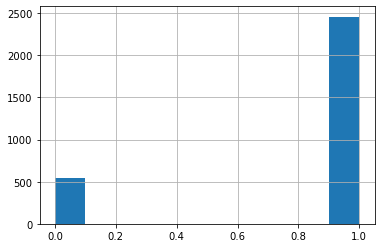

In [54]:
data.Win.hist()

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3004 entries, 0 to 3047
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fips              3004 non-null   int64  
 1   state             3004 non-null   object 
 2   county            3004 non-null   object 
 3   population        3004 non-null   int64  
 4   vaccinationRate   2873 non-null   float64
 5   cases             3004 non-null   int64  
 6   deaths            3004 non-null   int64  
 7   Region            3004 non-null   object 
 8   MedianIncome      3004 non-null   int64  
 9   PovertyEst        3004 non-null   int64  
 10  LaborForce        3004 non-null   int64  
 11  UnemploymentRate  3004 non-null   float64
 12  Older             3004 non-null   float64
 13  Urban             3004 non-null   float64
 14  Trump2016         3004 non-null   float64
 15  Trump2020         3004 non-null   float64
 16  RepGov            3004 non-null   float64


In [56]:
data.vaccinationRate = data.vaccinationRate.fillna(data.vaccinationRate.median())
data.vaccinationRate.describe()

count    3004.000000
mean        0.481162
std         0.111192
min         0.030000
25%         0.407000
50%         0.470000
75%         0.544000
max         1.304000
Name: vaccinationRate, dtype: float64

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3004 entries, 0 to 3047
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fips              3004 non-null   int64  
 1   state             3004 non-null   object 
 2   county            3004 non-null   object 
 3   population        3004 non-null   int64  
 4   vaccinationRate   3004 non-null   float64
 5   cases             3004 non-null   int64  
 6   deaths            3004 non-null   int64  
 7   Region            3004 non-null   object 
 8   MedianIncome      3004 non-null   int64  
 9   PovertyEst        3004 non-null   int64  
 10  LaborForce        3004 non-null   int64  
 11  UnemploymentRate  3004 non-null   float64
 12  Older             3004 non-null   float64
 13  Urban             3004 non-null   float64
 14  Trump2016         3004 non-null   float64
 15  Trump2020         3004 non-null   float64
 16  RepGov            3004 non-null   float64


In [58]:
data.isnull().sum()

fips                0
state               0
county              0
population          0
vaccinationRate     0
cases               0
deaths              0
Region              0
MedianIncome        0
PovertyEst          0
LaborForce          0
UnemploymentRate    0
Older               0
Urban               0
Trump2016           0
Trump2020           0
RepGov              0
Female              0
AdherentPercent     0
Win                 0
cases_per_cap       0
deaths_per_cap      0
Labor_rate          0
Poverty_rate        0
Fatality_rate       0
dtype: int64

In [59]:
#cut for landslide, win, or lose

In [60]:
data.Trump2020.head()

0    71.43681
1    76.17137
2    53.45123
3    78.42627
4    89.57156
Name: Trump2020, dtype: float64

## Transform Data

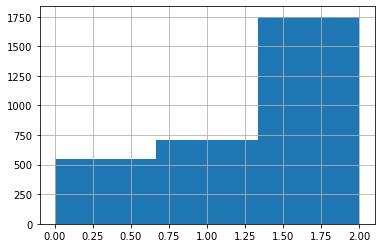

In [61]:
#create another column that defines a game as either a Flop, Average or a Hit
#using the quartile cut function, we can cut the column total_earnings into quartile/ranges 
#assign the tiles labels
data['result_cat']= pd.cut(data['Trump2020'], 
                           bins = [0., 50., 65., np.inf], 
                           labels=[0,1,2],
                          )

# lets evaluate the distribution of success
data["result_cat"].hist(bins=3)
plt.show()

In [62]:
data.head()

,fips,state,county,population,vaccinationRate,cases,deaths,Region,MedianIncome,PovertyEst,...,RepGov,Female,AdherentPercent,Win,cases_per_cap,deaths_per_cap,Labor_rate,Poverty_rate,Fatality_rate,result_cat
0,1001,AL,Autauga County,55869,0.384,11013,160,Southeast,67565,6242,...,1.0,1.0,67.687889,1,19712.183859,286.384220,0.462475,0.111726,0.014528,2
1,1003,AL,Baldwin County,223234,0.476,39818,593,Southeast,71135,20189,...,1.0,1.0,53.174000,1,17836.888646,265.640539,0.433460,0.090439,0.014893,2
2,1005,AL,Barbour County,24686,0.419,3850,81,Southeast,38866,5548,...,1.0,1.0,54.999000,1,15595.884307,328.121202,0.347849,0.224743,0.021039,1
3,1007,AL,Bibb County,22394,0.326,4524,95,Southeast,50907,3549,...,1.0,1.0,49.880000,1,20201.839779,424.220773,0.385818,0.158480,0.020999,2
4,1009,AL,Blount County,57826,0.296,11244,198,Southeast,55203,7525,...,1.0,1.0,65.162000,1,19444.540518,342.406530,0.426469,0.130132,0.017609,2


## Create Training and Test data sets

In [63]:
#by adding the stratify feature to the train_test_split, can ensure a more representative collection of data
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['result_cat','Trump2020', "Win", 'PovertyEst', "LaborForce" ,"cases", "deaths", 'county', 'fips']),
    data.result_cat, 
    test_size=0.2, 
    random_state=35, 
    stratify=data.Region
)

   
X_train.shape,X_test.shape,y_train.shape, y_test.shape 

((2403, 17), (601, 17), (2403,), (601,))

In [64]:
#now that we have the stratified test and training sets, no need for attribute income_cat in those sets
#X_train.drop(columns=["Region"], inplace=True)
#X_test.drop(columns=["Region"], inplace=True)

## Prepare Data

In [65]:
#data = data[ data.fips != 42045 ].copy() 

data['vaccinationRate'] = data.apply(lambda r: np.nan if r. vaccinationRate > 1 else r.vaccinationRate, axis =1)
#data[data.vaccinationRate >= 1, "vaccinationRate"] = np.nan

In [66]:
#show the size of the data sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2403, 17), (2403,), (601, 17), (601,))

In [67]:
cat_attribs = ["Region","state"]

#set the numerical attributes
num_attribs = list( X_train.drop(columns=cat_attribs) )

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled 
num_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="median")), 
    ('std_scaler', StandardScaler()),   
] )

#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs)    
])

In [68]:
from sklearn import set_config
set_config(display='diagram')
#should put with imports

In [69]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['population', 'vaccinationRate',
                                  'MedianIncome', 'UnemploymentRate', 'Older',
                                  'Urban', 'Trump2016', 'RepGov', 'Female',
                                  'AdherentPercent', 'cases_per_cap',
                                  'deaths_per_cap', 'Labor_rate',
                                  'Poverty_rate', 'Fatality_rate']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['Region', 'state'])])

In [70]:
#take the training data set and create an array of prepared data
X_train = full_pipeline.fit_transform(X_train)

In [71]:
X_test = full_pipeline.transform(X_test)

In [72]:
X_test.shape

(601, 70)

In [73]:
X_train.shape

(2403, 70)

In [74]:
#capture a list of all the features used in the model

#gets the order of encoded categories (if any)
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = []
if hasattr(cat_encoder, 'categories_'):
    for i in cat_encoder.categories_:
        cat_one_hot_attribs += list(i)
        
#combines the numeric and encoded features
attributes = list(num_attribs) + list(cat_one_hot_attribs)

attributes

['population',
 'vaccinationRate',
 'MedianIncome',
 'UnemploymentRate',
 'Older',
 'Urban',
 'Trump2016',
 'RepGov',
 'Female',
 'AdherentPercent',
 'cases_per_cap',
 'deaths_per_cap',
 'Labor_rate',
 'Poverty_rate',
 'Fatality_rate',
 'Far west',
 'Great Lakes',
 'Mideast',
 'New England',
 'Plains',
 'Rocky Mountain',
 'Southeast',
 'Southwest',
 'AL',
 'AR',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DE',
 'FL',
 'GA',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV']

## Make Predictions

In [81]:
#copies Delaware County data to a new dataset for later predictions
X_instance = data[ data.fips == 42045 ]
print(X_instance.shape)
X_instance = X_instance.drop(columns = ['Trump2020','result_cat','Win','county',"PovertyEst",'cases',"deaths", "LaborForce" ,'fips'])
X_instance.shape

(1, 26)


(1, 17)

In [82]:
#take the single instance and run it through the full_pipeline created above
X_prepared = full_pipeline.transform( X_instance )

In [83]:
data = data[ data.fips != 42045 ].copy() 

## Multiclass classification using RandomForest

In [84]:
#create the classification model
forest_clf = RandomForestClassifier(n_estimators=100, random_state=35)

#fit the model using the training data set
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=35)

In [85]:
forest_clf.predict(X_prepared)

array([0], dtype=int64)

In [86]:
forest_clf.predict_proba(X_prepared)

array([[0.94, 0.03, 0.03]])

In [87]:
#Use Cross Validation to get a more reliable Accuracy Score

In [88]:
#see how well the model peforms across a variety of cross sections
score = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")
np.mean(score)

0.9371618809821056

## Multiclass Classification using SGDClassifier

In [89]:
#create the classification model
#SDGClassifier by default is just a binary classifier that will run one-vs-the rest for each class
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=35)

#fit the model using the training data set
sgd_clf.fit(X_train, y_train)


SGDClassifier(random_state=35)

In [90]:
#see how well the model does on some sample data
#predict some random digit displayed above
sgd_clf.predict(X_prepared)

array([0], dtype=int64)

In [91]:
#see how well the model peforms across a variety of cross sections
score = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
np.mean(score)

0.9305035372451104

In [92]:
#get predictions aross 3 different folds using the default method (prediction scores)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [93]:
#display the confusion matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[ 415,   23,    0],
       [  40,  454,   73],
       [   1,   30, 1367]], dtype=int64)

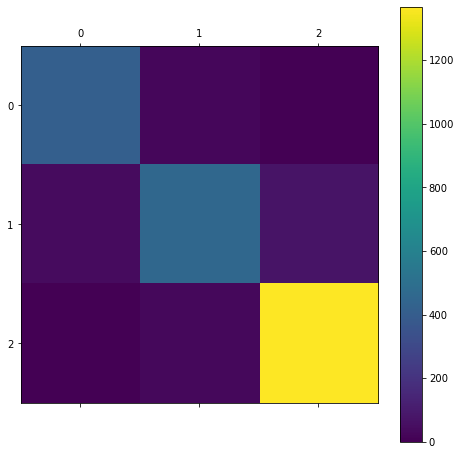

In [94]:
#plot the confusion matrix
plot_confusion_matrix(conf_mx)

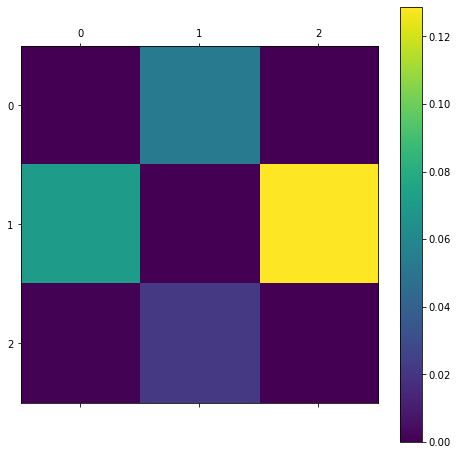

In [95]:
#plot the errors
#divide each value in the confusion matrix by the # of images in that corresponding class
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

#plot the matrix to see where there are problems 
np.fill_diagonal(norm_conf_mx,0)  #fill diagonal with zeros to see problems more clearly
plot_confusion_matrix(norm_conf_mx)

In [96]:
scores = precision_score(y_train, y_train_pred, average=None)
scores

array([0.91008772, 0.89546351, 0.94930556])

In [97]:
#calculate percision across entire data set
print("Precision Score: {:.4f}".format( precision_score(y_train, y_train_pred, average="weighted") ) )

Precision Score: 0.9295


In [98]:
#see how well the model performs on the test data set
y_pred = sgd_clf.predict(X_test)
print("Precision Score: {:.4f}".format(precision_score(y_pred, y_test, average="weighted") ))

Precision Score: 0.9431


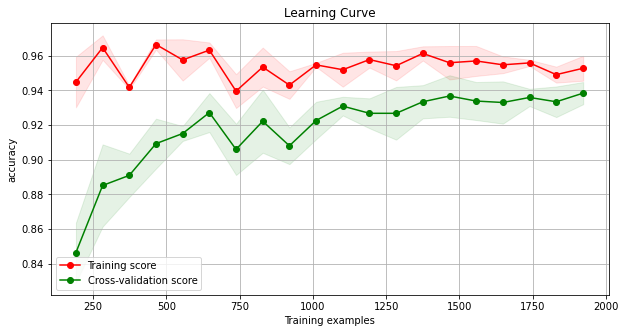

In [99]:
#review the learning curve
plot_learning_curve(sgd_clf, X_train, y_train, scoring="accuracy")

In [100]:
#try making a linear model fit data that is more likely non-linear
DEGREE = 2

#create a polynomial feature with degree based on variable DEGREE
poly_features=PolynomialFeatures(degree=DEGREE)

#transform our X by adding the square of each feature to the training set
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

X_train_poly.shape, X_test_poly.shape

((2403, 2556), (601, 2556))

In [101]:
# use the new, complex data set to train a new model
model_poly = LogisticRegression()

model_poly.fit(X_train_poly, y_train)

#compare the predicted to the actuals
acc = model_poly.score(X_train_poly, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 99.92%


In [102]:
#compare the predicted to the actuals
acc = model_poly.score(X_test_poly, y_test)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 92.85%


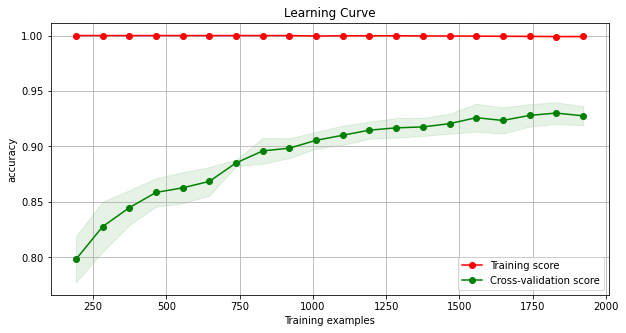

In [103]:
plot_learning_curve(model_poly,X_train_poly,y_train, scoring="accuracy")

In [104]:
#calcualte the predicted values
predictions = model_poly.predict(X_test_poly)

#compare the predicted to the actuals
print(" Accuracy Score: {:.2f}%".format( accuracy_score(y_test, predictions )*100 ))

 Accuracy Score: 92.85%


In [105]:
#run this prepared data through the polynomial transformation
X_example_poly = poly_features.transform(X_prepared)
X_example_poly.shape

(1, 2556)

In [106]:
#predict this instance
model_poly.predict(X_example_poly)

array([0], dtype=int64)

In [107]:
#probability of being a flop (0), average (1) or a hit (2)
model_poly.predict_proba( X_example_poly )

array([[9.99999999e-01, 6.40761735e-10, 2.10802934e-14]])

## Logistic Regression

### Train and Evaluate Model using Training Data

In [174]:
#create a linear regression model
log_reg=LogisticRegression(C=.75)      #regularization is defined by 1/C so a lower C value, a higher level of regularization

#fit the model to the training data set
log_reg.fit( X_train, y_train)

#calculated the accuracy (i.e. predicted vs. actual for the training data set)
acc = log_reg.score(X_train, y_train)
print('Accuracy: {:.4f}%'.format(acc*100))

Accuracy: 96.4211%


In [175]:
#use cross valudation to process the data 10 different ways using the logsitic regression model generated above
scores = cross_val_score(log_reg, X_train, y_train, cv=10)

# look at average across all folds
print('Accuracy: {:.4f}%'.format( scores.mean()*100 ) )

Accuracy: 94.7151%


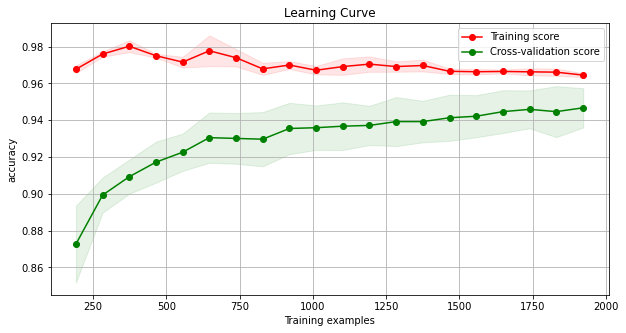

In [110]:
#review the learning curve
plot_learning_curve(log_reg, X_train, y_train, scoring="accuracy")

## Evaluate Model on Test Set

In [176]:
#calculated the accuracy (i.e. predicted vs. actual for the test data set)
acc = log_reg.score(X_test, y_test)
print('Accuracy: {:.4f}%'.format(acc*100))

Accuracy: 94.6755%


In [172]:
#predict the one instance
log_reg.predict( X_prepared )

array([0], dtype=int64)

In [173]:
#probability of being a flop (0), average (1) or a hit (2)
log_reg.predict_proba( X_prepared )

array([[9.99462898e-01, 5.37102054e-04, 1.90371085e-11]])

## Tune LogisticRegression

In [114]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'solver': ['saga', 'newton-cg', 'lbfgs', 'sag'],
     'multi_class': ['ovr', 'multinomial'],
     'C': [.5, .75, 1, 2]
    }
]

# train across 10 folds, that's a total of (4*6)*10=240 rounds of training 
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': [0.5, 0.75, 1, 2],
                          'multi_class': ['ovr', 'multinomial'],
                          'solver': ['saga', 'newton-cg', 'lbfgs', 'sag']}],
             return_train_score=True, scoring='accuracy')

In [115]:
#display the results of the GridSearchCV
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("Accuracy: {:,.2f}% - {}".format( mean_score*100, params) )

Accuracy: 92.26% - {'C': 0.5, 'multi_class': 'ovr', 'solver': 'saga'}
Accuracy: 92.55% - {'C': 0.5, 'multi_class': 'ovr', 'solver': 'newton-cg'}
Accuracy: 92.55% - {'C': 0.5, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Accuracy: 92.55% - {'C': 0.5, 'multi_class': 'ovr', 'solver': 'sag'}
Accuracy: 94.55% - {'C': 0.5, 'multi_class': 'multinomial', 'solver': 'saga'}
Accuracy: 94.67% - {'C': 0.5, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Accuracy: 94.71% - {'C': 0.5, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Accuracy: 94.67% - {'C': 0.5, 'multi_class': 'multinomial', 'solver': 'sag'}
Accuracy: 92.68% - {'C': 0.75, 'multi_class': 'ovr', 'solver': 'saga'}
Accuracy: 93.09% - {'C': 0.75, 'multi_class': 'ovr', 'solver': 'newton-cg'}
Accuracy: 93.09% - {'C': 0.75, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Accuracy: 93.05% - {'C': 0.75, 'multi_class': 'ovr', 'solver': 'sag'}
Accuracy: 94.67% - {'C': 0.75, 'multi_class': 'multinomial', 'solver': 'saga'}
Accuracy: 94.72% - {'C': 0.75,

In [116]:
#display the best solution
grid_search.best_params_

{'C': 2, 'multi_class': 'multinomial', 'solver': 'sag'}

## Create the best LogisticRegression Model

In [117]:
#use the parameters found above to create the model
model = LogisticRegression(**grid_search.best_params_)

#fit the model to the training data set
model.fit(X_train, y_train)

#calculated the accuracy (i.e. predicted vs. actual for the training data set)
acc = model.score(X_train, y_train)
print('Accuracy: {:.4f}%'.format(acc*100))

Accuracy: 96.5460%


In [118]:
#calculated the accuracy (i.e. predicted vs. actual for the test data set)
acc = model.score(X_test, y_test)
print('Accuracy: {:.4f}%'.format(acc*100))

Accuracy: 95.1747%


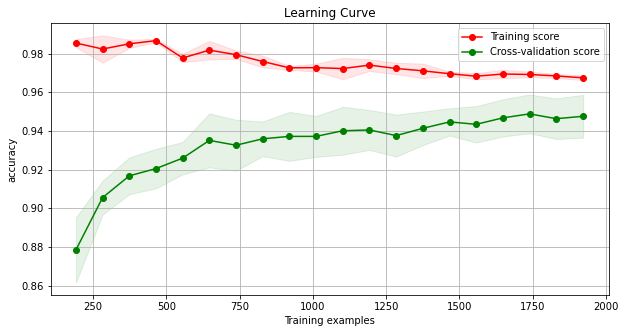

In [119]:
plot_learning_curve(model, X_train, y_train, scoring='accuracy')

In [120]:
#see how well the model peforms across a variety of cross sections
score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
print(" Accuracy Score: {:.4f}%".format(np.mean(score)*100))

 Accuracy Score: 94.3820%


In [121]:
#probability of being a flop (0), average (1) or a hit (2)
model.predict_proba( X_prepared )

array([[9.99888904e-01, 1.11096400e-04, 5.52775077e-14]])

In [122]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

#get predictions across 5 different folds using the default method (prediciton scores)
y_test_pred = cross_val_predict(model, X_test, y_test, cv=5)

conf_mat = confusion_matrix(y_test, y_test_pred)
conf_mat

array([[ 94,  13,   0],
       [ 13, 116,  13],
       [  0,   9, 343]], dtype=int64)

## Try RandomForestClassifer

### Train and Evaluate Model using Training Data

In [123]:
#create the classification model
forest_clf = RandomForestClassifier(n_estimators=70, random_state=35)

#fit the model using the training data set
forest_clf.fit(X_train, y_train)

#compare the predicted to the actuals
acc = forest_clf.score(X_train, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 100.00%


In [124]:
#see how well the model peforms across a variety of cross sections
score = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")
print(" Accuracy Score: {:.2f}%".format(np.mean(score)*100))

 Accuracy Score: 93.55%


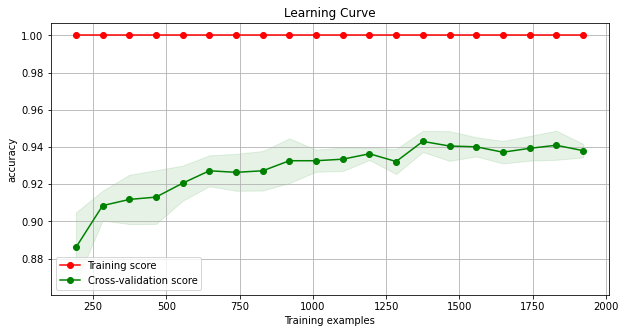

In [125]:
plot_learning_curve(forest_clf, X_train, y_train, scoring='accuracy')

## Evaluate Model on Test Set

In [126]:
#see how well the model performs on the test data set
y_pred = forest_clf.predict(X_test)

print(" Accuracy Score: {:.2f}%".format( accuracy_score(y_test, y_pred )*100 ))

 Accuracy Score: 94.01%


## Make a Prediction

In [127]:
forest_clf.predict(X_prepared)

array([0], dtype=int64)

In [128]:
#probability of being a flop (0), average (1) or a hit (2)
forest_clf.predict_proba( X_prepared )

array([[0.95714286, 0.01428571, 0.02857143]])

## Tune RandomForestClassifer

In [129]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'criterion':['gini', 'entropy'],
     'n_estimators': [10,100,1000],
     'max_features': ["auto","sqrt","log2"]
    }
]

# train across 10 folds, that's a total of (2*3*3)*10=180 rounds of training 
grid_search = GridSearchCV(RandomForestClassifier(random_state=35), param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=35),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [10, 100, 1000]}],
             return_train_score=True, scoring='accuracy')

In [130]:
#print the RMSE results from the CV and the paramaters used during each run 
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("Accuracy: {:,.2f}% - {}".format( mean_score*100, params) )

Accuracy: 92.43% - {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 10}
Accuracy: 94.30% - {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}
Accuracy: 94.63% - {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000}
Accuracy: 92.43% - {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}
Accuracy: 94.30% - {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
Accuracy: 94.63% - {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000}
Accuracy: 90.97% - {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 10}
Accuracy: 93.88% - {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
Accuracy: 93.92% - {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000}
Accuracy: 92.80% - {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 10}
Accuracy: 94.01% - {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 100}
Accuracy: 94.51% - {'criterion': 'entropy', 'max_

In [131]:
#display the best soluiton
grid_search.best_params_

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000}

## Create the best RandomForestClassifer

In [132]:
#use the parameters found above to create the model
model = RandomForestClassifier(**grid_search.best_params_)

#fit the model to the training data set
model.fit(X_train, y_train)

#compare the predicted to the actuals
acc = model.score(X_train, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 100.00%


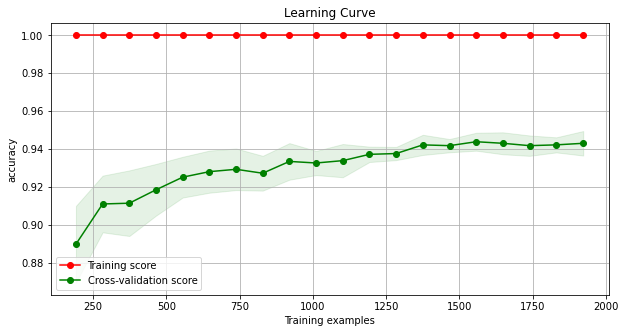

In [133]:
plot_learning_curve(model, X_train, y_train,scoring="accuracy")

## Evaluate best RandomForestClassifer on Test Set

In [134]:
#see how well the model performs on the test data set
y_pred = model.predict(X_test)

print(" Accuracy Score: {:.2f}%".format( accuracy_score(y_test, y_pred )*100 ))

 Accuracy Score: 95.17%


## Add Complexity using PolynomialFeatures

In [135]:
#try making a linear model fit data that is more likely non-linear
DEGREE = 1

#create a polynomial feature with degree based on variable DEGREE
poly_features=PolynomialFeatures(degree=DEGREE)

#transform our X by adding the square of each feature to the training set
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

X_train_poly.shape, X_test_poly.shape

((2403, 71), (601, 71))

In [136]:
# use the new, complex data set to train a new model
model_poly = LogisticRegression()

model_poly.fit(X_train_poly, y_train)

#compare the predicted to the actuals
acc = model_poly.score(X_train_poly, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 96.55%


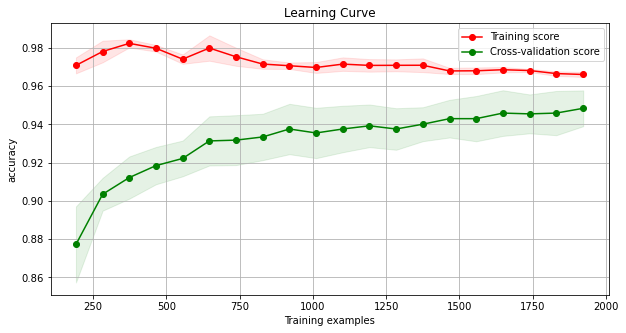

In [137]:
plot_learning_curve(model_poly,X_train_poly,y_train, scoring="accuracy")

In [138]:
#calcualte the predicted values
predictions = model_poly.predict(X_test_poly)

#compare the predicted to the actuals
print(" Accuracy Score: {:.2f}%".format( accuracy_score(y_test, predictions )*100 ))

 Accuracy Score: 95.17%


## Make a Prediction

In [139]:
X_prepared

array([[ 1.54055944,  0.99192221,  1.25376478,  1.06662712, -0.55253898,
         1.84934992, -1.70774285, -1.19161218, -0.45556305,  0.68180089,
        -0.87289708, -0.22267696,  0.80998379, -0.88922567,  0.24834471,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [140]:
#run this prepared data through the polynomial transformation
X_example_poly = poly_features.transform(X_prepared)
X_example_poly.shape

(1, 71)

In [141]:
#predict this instance
model_poly.predict(X_example_poly)

array([0], dtype=int64)

In [142]:
#probability of being a flop (0), average (1) or a hit (2)
model_poly.predict_proba( X_example_poly )

array([[9.99706811e-01, 2.93189134e-04, 2.58940151e-12]])

## Binary Classification

In [156]:
#by adding the stratify feature to the train_test_split, can ensure a more representative collection of data
X_trainBin, X_testBin, y_trainBin, y_testBin = train_test_split(
    data.drop(columns=['result_cat','Win','Trump2020', 'county',"PovertyEst","LaborForce","deaths","cases", 'fips']),
    data.Win, 
    test_size=0.2, 
    random_state=35, 
    stratify=data.Region
)

   
X_trainBin.shape,X_testBin.shape,y_trainBin.shape, y_testBin.shape 

((2402, 17), (601, 17), (2402,), (601,))

In [157]:
cat_attribs = ["Region","state"]

#set the numerical attributes
num_attribs = list( X_trainBin.drop(columns=cat_attribs) )


#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled 
num_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="mean")), 
    ('std_scaler', StandardScaler()),   
] )

#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs)    
])

In [158]:
#take the training data set and create an array of prepared data
X_trainBin = full_pipeline.fit_transform(X_trainBin)

In [159]:
X_testBin = full_pipeline.transform(X_testBin)

In [160]:
X_testBin.shape

(601, 70)

In [161]:
#create the classification model
sgd_clf = SGDClassifier( random_state=35)

#fit the model using the training data set
sgd_clf.fit(X_trainBin, y_trainBin)

SGDClassifier(random_state=35)

In [162]:
#calculated the accuracy (i.e. predicted vs. actual for the training data set)
acc = sgd_clf.score(X_trainBin, y_trainBin)
print('Accuracy: {:.5f}%'.format(acc*100))

Accuracy: 98.54288%


In [163]:
#calculated the accuracy (i.e. predicted vs. actual for the training data set)
acc = sgd_clf.score(X_testBin, y_testBin)
print('Accuracy: {:.5f}%'.format(acc*100))

Accuracy: 97.17138%


In [164]:
#see how well the model peforms across a variety of cross sections
score = cross_val_score(sgd_clf, X_trainBin, y_trainBin, cv=3, scoring="accuracy")
np.mean(score)

0.9737734082397004

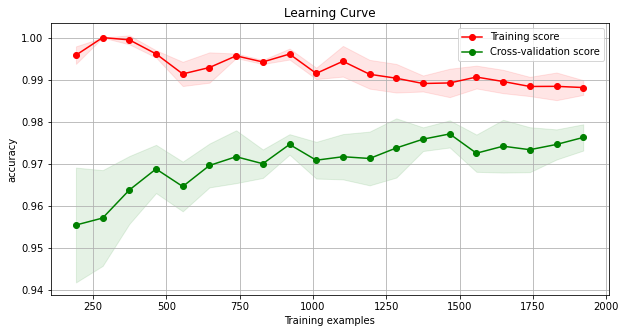

In [152]:
plot_learning_curve(sgd_clf,X_trainBin,y_trainBin, scoring="accuracy")

In [165]:
#get predictions aross 3 different folds using the default method (prediction scores)
y_train_pred = cross_val_predict(sgd_clf, X_trainBin, y_trainBin, cv=3)

In [166]:
#display the confusion matrix
confusion_matrix(y_trainBin, y_trainBin)

array([[ 437,    0],
       [   0, 1965]], dtype=int64)

In [167]:
#see how well the model does on some sample data
#predict some random digit displayed above
sgd_clf.predict(X_prepared)

array([0], dtype=int64)

In [168]:
#calculate measures
print("Precision Score: {:.2f}".format( precision_score(y_trainBin, y_train_pred) ) )
print("   Recall Score: {:.2f}".format( recall_score(y_trainBin, y_train_pred) ) )
print("       F1 Score: {:.2f}".format( f1_score(y_trainBin, y_train_pred) ) )

Precision Score: 0.98
   Recall Score: 0.99
       F1 Score: 0.98


In [169]:
calibrator = CalibratedClassifierCV(sgd_clf, cv='prefit')
sgd_clf=calibrator.fit(X_trainBin, y_trainBin)

In [170]:
sgd_clf.predict_proba(X_prepared)

array([[9.99983947e-01, 1.60533958e-05]])